# 承接rag-pre的进阶操作

**包括链和agent，实现历史对话**

In [3]:
import getpass
import os

os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT_ID"] = "project-1"
os.environ["LANGSMITH_PROJECT_NAME"] = "example rag"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = "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"

from langchain_deepseek.chat_models import ChatDeepSeek  # 导入 DeepSeek 的聊天模型
from langchain_huggingface import HuggingFaceEmbeddings # 导入 HuggingFace 的嵌入模型
from langchain.chains import RetrievalQA # 导入检索问答链
from langchain.prompts import PromptTemplate # 导入提示模板
from langchain.chains import LLMChain # 导入 LLM 链
from langchain.memory import ConversationBufferMemory # 导入对话缓冲区内存
from langchain_chroma import Chroma # 导入 Chroma 向量存储


deepseek_api_key = "sk-fffbb9b8a78d436a91a4780356b67a93"

llm = ChatDeepSeek(model="deepseek-chat", api_key = deepseek_api_key)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [4]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

USER_AGENT environment variable not set, consider setting it to identify your requests.


## 1. 信息状态

In [5]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

### 1. toolmessage用于检索文档

In [6]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [ ]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    # Reverse to get the order of retrieval
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [8]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

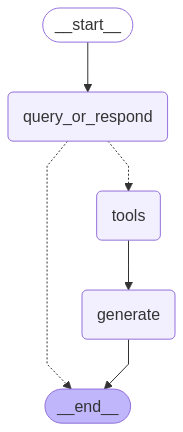

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [11]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_0_294017aa-ca0b-4bf8-b918-6c08c8495054)
 Call ID: call_0_294017aa-ca0b-4bf8-b918-6c08c8495054
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps